In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
from sklearn.model_selection import train_test_split

# For data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

## Import Data

In [2]:
# Read the data
X_full = pd.read_csv('datasets/train.csv', index_col='Id')
X_test_full = pd.read_csv('datasets/test.csv', index_col='Id')

In [3]:
# Remove rows with missing target
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)

## Detect and Delete Outliers

In [4]:
X_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


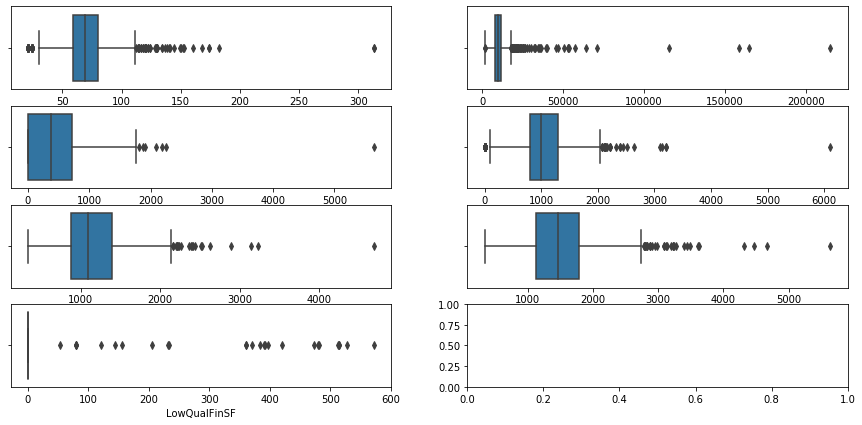

In [5]:
# Use  box plot to visualise the and detect outliers
columns_outliers = ["LotFrontage", "LotArea", "BsmtFinSF1", "TotalBsmtSF", "1stFlrSF", "GrLivArea", "LowQualFinSF"]

fig, axes = plt.subplots(4, 2, figsize=(15, 7))
axes = axes.flatten()

for column, axis in zip(columns_outliers, axes):
    sns.boxplot(x=X_full[column], ax=axis)

In [6]:
# Delete outliers
X_full = X_full.drop(X_full['LotFrontage'] [X_full['LotFrontage']>200].index)
X_full = X_full.drop(X_full['LotArea'] [X_full['LotArea']>100000].index)
X_full = X_full.drop(X_full['BsmtFinSF1'] [X_full['BsmtFinSF1']>4000].index)
X_full = X_full.drop(X_full['TotalBsmtSF'] [X_full['TotalBsmtSF']>6000].index)
X_full = X_full.drop(X_full['1stFlrSF'] [X_full['1stFlrSF']>4000].index)
X_full = X_full.drop(X_full.GrLivArea [(X_full['GrLivArea']>4000) & (X_full['SalePrice']<300000)].index)
X_full = X_full.drop(X_full.LowQualFinSF    [X_full['LowQualFinSF']>550].index)

## Deal with Missing Values

In [7]:
from datacleaning import missing_percentage

In [8]:
missing = missing_percentage(X_full)
missing = missing.T

In [9]:
# Let't categorize the missing the features
# Some null values 
zero_cols = [col for col in missing.columns if (X_full[col].dtype!="O" and col!="LotFrontage")]
freq_cols = [col for col in missing.columns if (missing[col]["Total"]<=2 and col not in zero_cols)]
none_cols = [col for col in missing.columns if (X_full[col].dtype=="O" and col!="MSZoning")]


# Some N/A values mean that a particular house doesn't have the feature described (eg; A pool, an alley)
# In such cases, numerical values will be marked as 0 and categorical features will be categorized by a new class, None
# In cases where the null values occur in a few houses, it is possible that there're actual missing values
# In such cases, we will replace them with the mode

for col in zero_cols:
    X_full[col].replace(np.nan, 0, inplace=True)
    
for col in freq_cols:
    X_full[col].replace(np.nan, X_full[col].mode()[0], inplace=True)
    
for col in none_cols:
    X_full[col].replace(np.nan, "None", inplace=True)

In [10]:
# We can't replace all NaN values in the MSSubClass and LotFrontage
# with zeros (O can't be a reasonable prediction of the null values)
# We can use other features to make a fairly accurate estimation of the null values

# I can modularise this part by creating a function called strategic_imputation

# MSSubClass (the type of dwelling) may help predict the type of zone
X_full["MSZoning"] = X_full.groupby("MSSubClass")["MSZoning"].apply(lambda x:x.fillna(x.mode()[0]))

# Neighbourhood may help predict the LotFrontage
X_full["LotFrontage"] = X_full.groupby("Neighborhood")["LotFrontage"].apply(lambda x:x.fillna(x.median()))

## Feature Engineering

In [11]:
# Some features have some values which are less than 10
# If a feature has two or more of such values, we will place it the other list
# Then, we will classify those mini values together as Other' 

others = [feature for feature in X_full.columns if ((X_full[feature].value_counts()<10).sum() > 1) and (X_full[feature].dtype=="O")]

for col in others:
    indices = X_full[col].isin(X_full[col].value_counts()[X_full[col].value_counts()<10].index)
    X_full[col][indices] = "Other"

C:\Users\Hp\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Drop Columns with High Correlations with Other Columns

In [12]:
# Numerical cols with high correlation delete
attributes_drop = ['MiscVal', 'MSSubClass', 'MoSold', 'YrSold', 
                   'GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd'] # high corr with other attributes

X_full = X_full.drop(attributes_drop, axis=1)

## Separate Targets from Predictors

In [13]:
# Separate target from predictors
y = X_full.SalePrice              
X_full.drop(['SalePrice'], axis=1, inplace=True)

## Set aside Validation data from Training data

In [14]:
# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, train_size=0.8, test_size=0.2, random_state=0)

## Categorical Data

In [15]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and X_train_full[cname].dtype == "object"]

In [16]:
# Select numeric columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

In [17]:
# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [18]:
# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

## XGBoost Model Prediction

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [20]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, low_cardinality_cols)
    ])

In [21]:
# Define the model
my_model_2 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                          colsample_bynode=1, colsample_bytree=0.4, gamma=0.0002,
                          importance_type='gain', learning_rate=0.009,max_delta_step=0,
                          max_depth=8, min_child_weight=0, missing=None,n_estimators=3232,
                          n_jobs=1, nthread=None, objective='reg:squarederror',random_state=0,
                          reg_alpha=0.000035, reg_lambda=1, scale_pos_weight=1,seed=42,
                          silent=None, subsample=0.45, verbosity=1)


In [22]:
# Fit the model
my_model_2.fit(X_train, y_train) 


# Get predictions
predictions_2 = my_model_2.predict(X_valid) # Your code here

# Calculate MAE

from sklearn.metrics import mean_absolute_error
mae_2 = mean_absolute_error(predictions_2, y_valid) # Your code here

# Print MAE
print("Mean Absolute Error:", mae_2)

Mean Absolute Error: 13576.796928694159


In [23]:
my_model = my_model_2

preds_test = my_model.predict(X_test)

# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)